<a href="https://colab.research.google.com/github/adikush1/Modelling-And-Forecasting-Exchange-Rate/blob/main/Exchange_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [11]:
train_df=pd.read_excel("/content/drive/MyDrive/forex_model.xlsx",sheet_name="Final_forex")
train_df.head()

,Year,GDP growth (annual %),Trade Deficit (% of GDP),"Total reserves (includes gold, current US$)",FDI (% GDP),"Inflation, consumer prices (annual %)",Population growth (annual %),Real Interest Rates,Crude Oil Price (dollar per barrel),Exchange Rates
0,1978,5.71,0.28,8.316116e+09,0.013175,2.52,2.24,10.774631,9.00,8.192840
1,1979,-5.24,1.42,1.181541e+10,0.031747,6.28,2.25,-1.061146,12.64,8.125791
2,1980,6.74,3.11,1.200979e+10,0.042485,11.35,2.29,4.476508,21.59,7.862945
3,1981,6.01,2.63,8.108838e+09,0.047506,13.11,2.30,5.118237,31.77,8.658523
4,1982,3.48,2.16,8.241562e+09,0.035912,7.89,2.29,7.774707,28.52,9.455132


## ***Correlation***

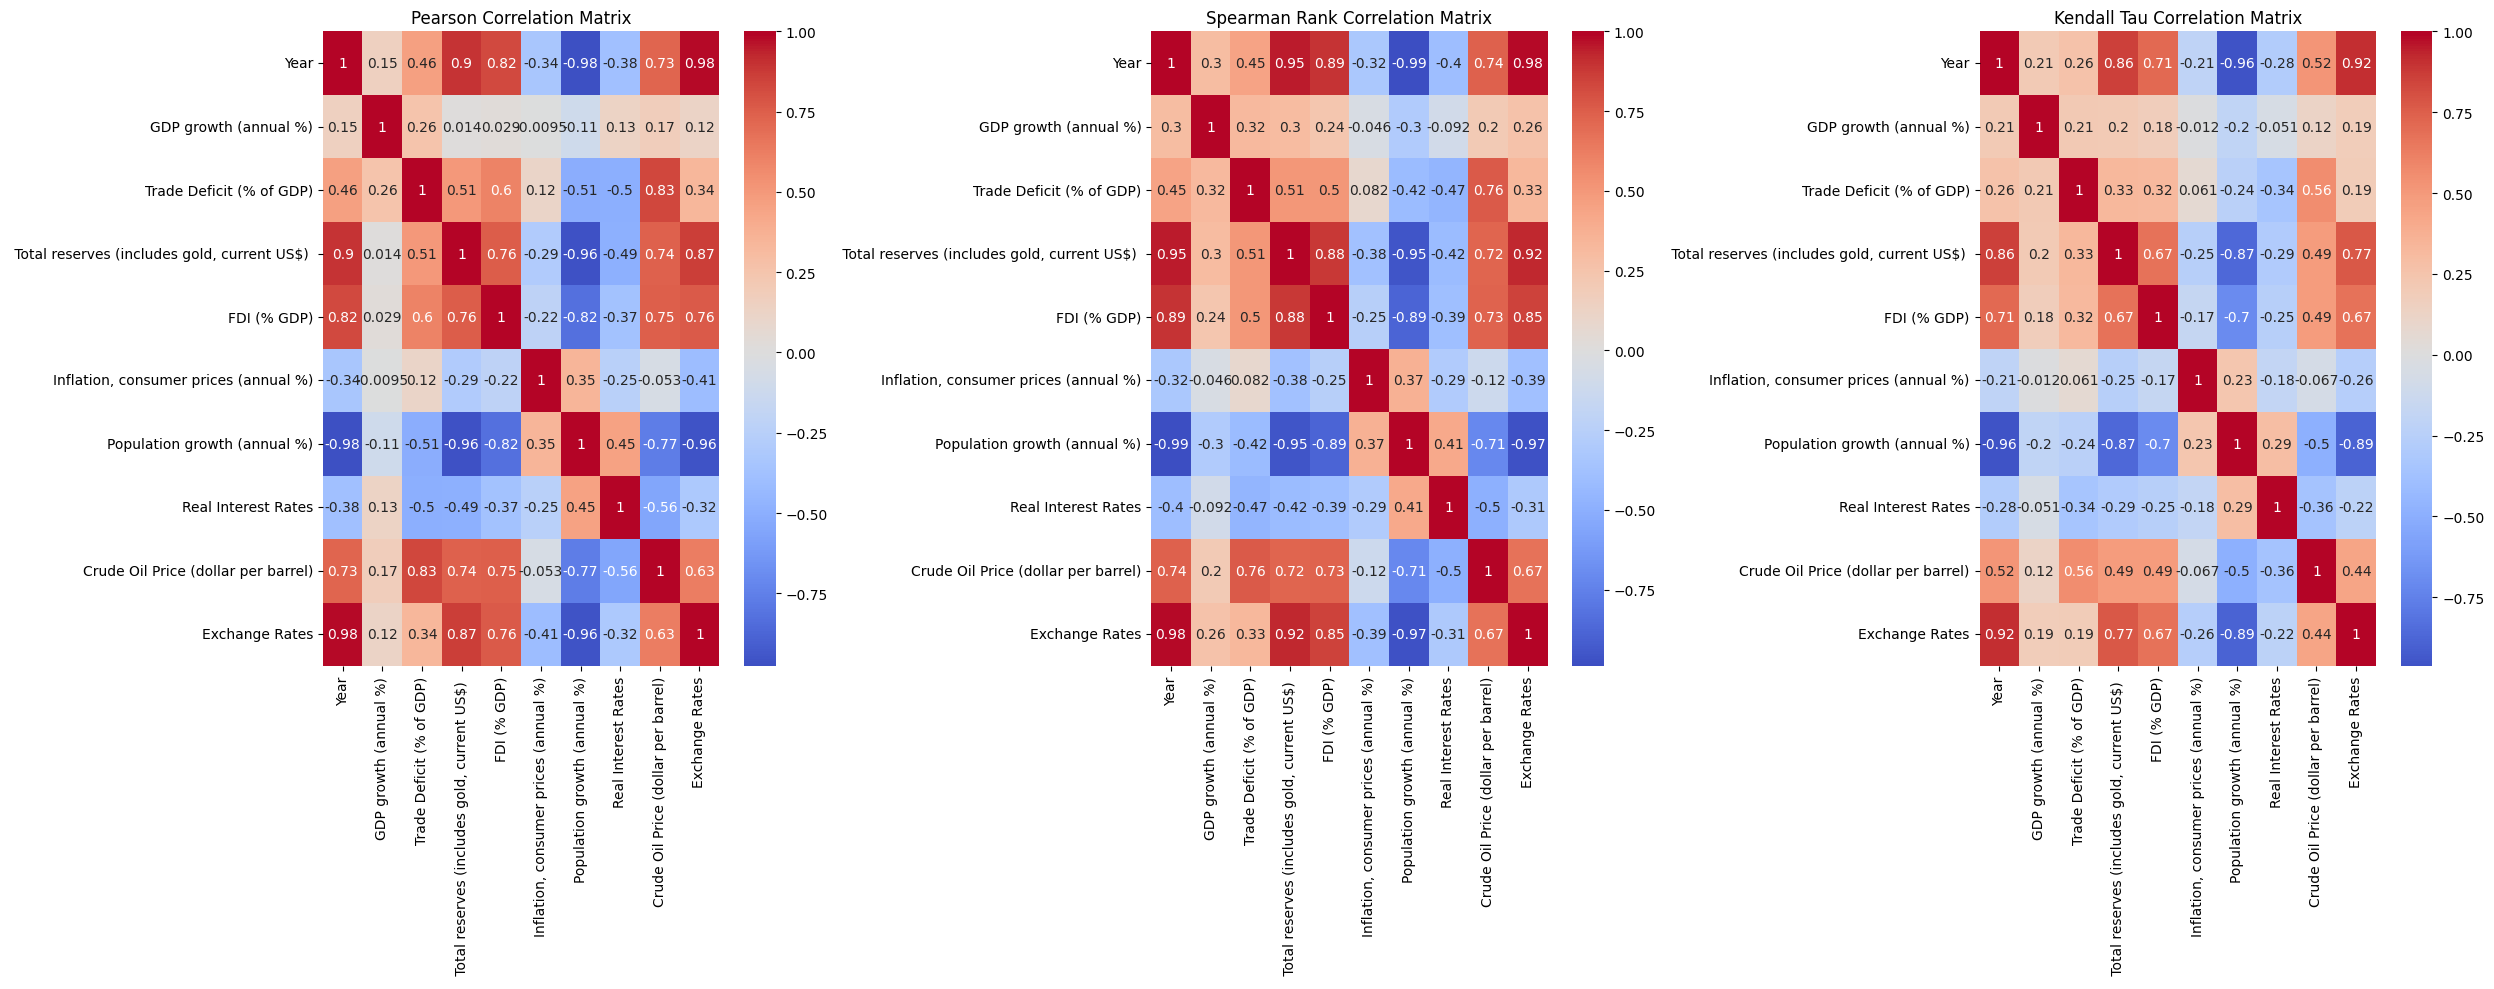

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
# train_df = pd.read_csv("your_dataset.csv")

# Calculate correlation matrices
pearson_corr_matrix = train_df.corr(method='pearson')
spearman_corr_matrix = train_df.corr(method='spearman')
kendall_corr_matrix = train_df.corr(method='kendall')

# Create heatmaps using Seaborn
plt.figure(figsize=(25, 10))

# Pearson Correlation Matrix Heatmap
plt.subplot(131)
sns.heatmap(pearson_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Pearson Correlation Matrix")

# Spearman Rank Correlation Matrix Heatmap
plt.subplot(132)
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Spearman Rank Correlation Matrix")

# Kendall Tau Correlation Matrix Heatmap
plt.subplot(133)
sns.heatmap(kendall_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Kendall Tau Correlation Matrix")

plt.tight_layout()
plt.show()


1. Logically, exchange rate and trade balance are negatively correlated which says if the trade balance is positive, INR will appreciate.
2. Secondly, exchange rate and real interest rate are negatively correlated which says if interest rate is high then the foreign investment will increase and so currency appreciates.


## ***Multicollinearity using VIF***

In [13]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your dataset
# train_df = pd.read_csv('your_dataset.csv')

# Calculate VIF scores
vif_data = pd.DataFrame()
vif_data["feature"] = train_df.columns
vif_data["VIF"] = [variance_inflation_factor(train_df.values, i) for i in range(len(train_df.columns))]

# Print VIF scores
for feature, vif in zip(vif_data["feature"], vif_data["VIF"]):
    print(f"{feature}: {vif:.2f}")


Year: 10836.93
GDP growth (annual %): 2.02
Trade Deficit (% of GDP): 4.88
 Total reserves (includes gold, current US$) : 141.83
FDI (% GDP): 6.61
Inflation, consumer prices (annual %): 1.97
Population growth (annual %): 419.80
Real Interest Rates: 2.86
Crude Oil Price (dollar per barrel): 8.44
Exchange Rates: 105.33


## ***Scaling using Z score***

In [14]:

from sklearn.preprocessing import StandardScaler

independent_features = train_df.drop("Exchange Rates", axis=1)  # Drop the dependent variable

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the independent features using the scaler
scaled_features = scaler.fit_transform(independent_features)

# Create a DataFrame with the scaled independent features
scaled_independent_df = pd.DataFrame(scaled_features, columns=independent_features.columns)

# Combine the scaled independent features with the dependent variable
scaled_train_df = pd.concat([scaled_independent_df, train_df["Exchange Rates"]], axis=1)

# Display the scaled DataFrame
print(scaled_train_df.head())


       Year  GDP growth (annual %)  Trade Deficit (% of GDP)  \
0 -1.693979               0.026653                 -1.219517   
1 -1.616980              -3.457015                 -0.514284   
2 -1.539981               0.354341                  0.531193   
3 -1.462982               0.122096                  0.234253   
4 -1.385983              -0.682806                 -0.056501   

    Total reserves (includes gold, current US$)   FDI (% GDP)  \
0                                      -0.812697    -1.040050   
1                                      -0.794015    -1.019180   
2                                      -0.792978    -1.007113   
3                                      -0.813804    -1.001471   
4                                      -0.813095    -1.014499   

   Inflation, consumer prices (annual %)  Population growth (annual %)  \
0                              -1.649692                      1.066668   
1                              -0.407191                      1.088106   
2 

### ***ARIMA TIME SERIES MODEL***

In [15]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Assuming your scaled dataset contains features and a scaled target "Exchange Rates"
scaled_features = scaled_train_df.drop("Exchange Rates", axis=1)
scaled_target = scaled_train_df["Exchange Rates"]

# Split the data into training and test sets
train_size = int(0.8 * len(scaled_features))
train_features, test_features = scaled_features[:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[:train_size], scaled_target[train_size:]

# Fit an ARIMA model to the scaled training target
p, d, q = 1, 1, 1  # Set appropriate values for ARIMA order
model = ARIMA(train_target, order=(p, d, q))
model_fit = model.fit()

# Forecast future values using the ARIMA model
forecast_steps = len(test_features)
forecast = model_fit.forecast(steps=forecast_steps)

# Calculate evaluation metrics for ARIMA
arima_rmse = np.sqrt(mean_squared_error(test_target, forecast))
arima_mae = mean_absolute_error(test_target, forecast)
arima_mape = np.mean(np.abs((test_target - forecast) / test_target)) * 100

print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAE:", arima_mae)
print("ARIMA MAPE:", arima_mape)


ARIMA RMSE: 1.6781641953418283
ARIMA MAE: 1.3411614022937357
ARIMA MAPE: 1.9106386624838878


## ***ARMA TIME SERIES MODEL***

In [16]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming your scaled dataset contains features and a scaled target "Exchange Rates"
scaled_features = scaled_train_df.drop("Exchange Rates", axis=1)
scaled_target = scaled_train_df["Exchange Rates"]

# Split the data into training and test sets
train_size = int(0.8 * len(scaled_features))
train_features, test_features = scaled_features[:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[:train_size], scaled_target[train_size:]

# Fit an ARMA model to the scaled training target
p, q = 1, 1  # Set appropriate values for ARMA order
d = 0  # Since we're using ARMA, differencing is not needed
model = ARIMA(train_target, order=(p, d, q))
model_fit = model.fit()

# Forecast future values using the ARMA model
forecast_steps = len(test_features)
forecast = model_fit.forecast(steps=forecast_steps)

# Calculate evaluation metrics for ARMA
arma_rmse = np.sqrt(mean_squared_error(test_target, forecast))
arma_mae = mean_absolute_error(test_target, forecast)
arma_mape = np.mean(np.abs((test_target - forecast) / test_target)) * 100

print("ARMA RMSE:", arma_rmse)
print("ARMA MAE:", arma_mae)
print("ARMA MAPE:", arma_mape)


ARMA RMSE: 12.32428461267272
ARMA MAE: 10.785028408284672
ARMA MAPE: 15.019397944703877


## ***LINEAR REGRESSION***

In [17]:

import statsmodels.api as sm


# Assuming your scaled dataset contains features and a scaled target "Exchange Rate"
scaled_features = scaled_train_df.drop("Exchange Rates", axis=1)  # Replace with your feature columns
scaled_target = scaled_train_df["Exchange Rates"]

# Add a constant term to the features for the intercept in the linear regression
scaled_features = sm.add_constant(scaled_features)

# Split the data into training and test sets
train_size = int(0.8 * len(scaled_features))
train_features, test_features = scaled_features[:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[:train_size], scaled_target[train_size:]

# Fit Linear Regression using Ordinary Least Squares (OLS)
model = sm.OLS(train_target, train_features)
result = model.fit()

# Predict using the fitted model
predictions = result.predict(test_features)

# Calculate evaluation metrics for Linear Regression
rmse = np.sqrt(np.mean((test_target - predictions) ** 2))
mae = np.mean(np.abs(test_target - predictions))
mape = np.mean(np.abs((test_target - predictions) / test_target)) * 100

print("Linear Regression RMSE:", rmse)
print("Linear Regression MAE:", mae)
print("Linear Regression MAPE:", mape)

# Print R-squared value from the fitted model
print("R-squared:", result.rsquared)


Linear Regression RMSE: 9.255706417694132
Linear Regression MAE: 8.01772449970639
Linear Regression MAPE: 11.243978034336033
R-squared: 0.985664561990876


## ***Comparison of Statsmodel and Sklearn Libraries R_2_Score***

In [18]:

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Load your scaled dataset
# scaled_data = pd.read_csv("your_scaled_dataset.csv")

# Assuming your scaled dataset contains features and a scaled target "Exchange Rate"
scaled_features = scaled_train_df.drop("Exchange Rates", axis=1)  # Replace with your feature columns
scaled_target = scaled_train_df["Exchange Rates"]

# Split the data into training and test sets
train_size = int(0.8 * len(scaled_features))
train_features, test_features = scaled_features[:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[:train_size], scaled_target[train_size:]

# Fit Linear Regression using sklearn's LinearRegression
sklearn_model = LinearRegression()
sklearn_model.fit(train_features, train_target)
sklearn_predictions = sklearn_model.predict(test_features)

# Calculate evaluation metrics for sklearn Linear Regression
sklearn_rmse = np.sqrt(np.mean((test_target - sklearn_predictions) ** 2))
sklearn_mae = np.mean(np.abs(test_target - sklearn_predictions))
sklearn_mape = np.mean(np.abs((test_target - sklearn_predictions) / test_target)) * 100

print("Sklearn Linear Regression RMSE:", sklearn_rmse)
print("Sklearn Linear Regression MAE:", sklearn_mae)
print("Sklearn Linear Regression MAPE:", sklearn_mape)

# Fit Linear Regression using statsmodels' OLS
statsmodels_features = sm.add_constant(train_features)
statsmodels_model = sm.OLS(train_target, statsmodels_features)
statsmodels_result = statsmodels_model.fit()
statsmodels_predictions = statsmodels_result.predict(sm.add_constant(test_features))

# Calculate evaluation metrics for statsmodels OLS
statsmodels_rmse = np.sqrt(np.mean((test_target - statsmodels_predictions) ** 2))
statsmodels_mae = np.mean(np.abs(test_target - statsmodels_predictions))
statsmodels_mape = np.mean(np.abs((test_target - statsmodels_predictions) / test_target)) * 100

print("Statsmodels Linear Regression RMSE:", statsmodels_rmse)
print("Statsmodels Linear Regression MAE:", statsmodels_mae)
print("Statsmodels Linear Regression MAPE:", statsmodels_mape)

# Print R-squared values from both implementations
print("Sklearn Linear Regression R-squared:", sklearn_model.score(test_features, test_target))
print("Statsmodels Linear Regression R-squared:", statsmodels_result.rsquared)


Sklearn Linear Regression RMSE: 9.255706417694176
Sklearn Linear Regression MAE: 8.01772449970643
Sklearn Linear Regression MAPE: 11.24397803433609
Statsmodels Linear Regression RMSE: 9.255706417694132
Statsmodels Linear Regression MAE: 8.01772449970639
Statsmodels Linear Regression MAPE: 11.243978034336033
Sklearn Linear Regression R-squared: -2.0871854415654205
Statsmodels Linear Regression R-squared: 0.985664561990876
